# Проект: Определение рыночной стоимости автомобиля с помощью модели машинного обучения

## Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- качество предсказания;<br>
- время обучения модели;<br>
- время предсказания модели.

### Цель исследования

1. Построить модели для определения рыночной стоимости автомобиля, выбрать лучшую и проверить ее качество.

### Ход исследования

1. Загрузка данных;
2. Предобработка данных;
3. Подготовка данных;
4. Обучение моделей;
5. Анализ моделей;
6. Выбор лучшей модели и проверка ее качества.

## Подготовка данных (от этапа загрузки данных до подготовки данных)

### Загрузка данных

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print('Google Drive не установлен.')

Mounted at /content/drive


In [ ]:
!pip install --upgrade scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 37.1 MB/s eta 0:00:00


In [ ]:
pip install missingno -q

In [ ]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm -q

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [ ]:
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error #root_mean_squared_error

from catboost import CatBoostRegressor
import lightgbm as lgb
import missingno as msno
import phik

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# объявление констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
# загрузка данных

# Определяем, где мы находимся
if 'google.colab' in sys.modules:
    # Google Colab
    dataset_url = '/content/drive/MyDrive/Colab Notebooks/10. Numerical methods/datasets/autos.csv'
else:
    # локальная среда (Jupyter)
    dataset_url = '/datasets/autos.csv'

autos = pd.read_csv(dataset_url)

In [ ]:
# общий взгляд на данные
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
# просмотр краткого содержания данных
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим пропущенные значения, также можно привести признаки к змеиному регистру.

### Предобработка данных

#### Корректировка наименований колонок

In [ ]:
autos.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in autos.columns]
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Изменение типов данных

Не требуется (но при большом объеме данных в DataFrame можно оптимизировать использование памяти и перевести int64 в int32 ).

#### Пропущенные значения

<AxesSubplot:>

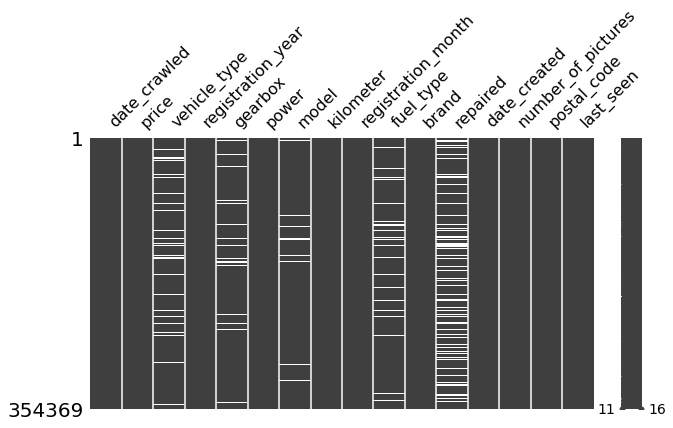

In [ ]:
# визуальный осмотр пропущенных значений
%matplotlib inline
msno.matrix(autos, figsize=(10,5))

<AxesSubplot:>

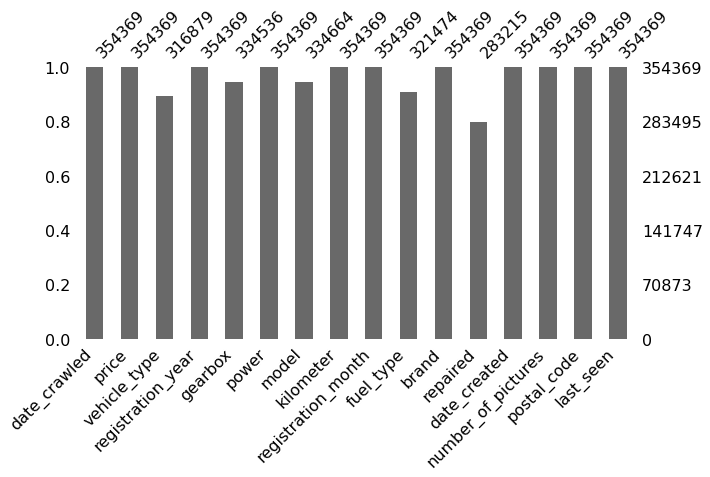

In [ ]:
msno.bar(autos, figsize=(10,5))

In [ ]:
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


Удалять все пропуски не будем, т.к. датасет потеряет много информации. <br><br>
Заполнить пропуски в типе кузова (здесь больше всего пропусков, порядка 12% от общего количества объектов) можно было бы различными значениями (при наличии информации о модели):

In [ ]:
# посмотрим на список уникальных пар vehicle_type - model
print(autos[['vehicle_type', 'model']].drop_duplicates())

       vehicle_type    model
0               NaN     golf
1             coupe      NaN
2               suv    grand
3             small     golf
4             small    fabia
...             ...      ...
339350          suv  m_reihe
340012  convertible      fox
344028        other     note
351588        coupe   zafira
352538        coupe   toledo

[1381 rows x 2 columns]


1381 уникальная пара (включая пропуски). Заполнение пропусков различными значениями в зависимости от модели в данном случае времязатратно при минимальном 'выхлопе'. Заполним NaN значением 'other'.

In [ ]:
# Python стал предупреждать, что inplace не будет работать так, как сейчас, в след. версии Pandas 3.0
# пропуски в vehicle_type, model, fuel_ytpe заменим на 'other' (такое значение уже есть в признаке)
autos['vehicle_type'] = autos['vehicle_type'].fillna('other')
autos['model'] = autos['model'].fillna('other')
autos['fuel_type'] = autos['fuel_type'].fillna('not_specified')

In [ ]:
# пропуски в gearbox и repaired заполним значением 'not_specified'
autos['gearbox'] = autos['gearbox'].fillna('not_specified')
autos['repaired'] = autos['repaired'].fillna('not_specified')

In [ ]:
autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

#### Поиск и удаление дубликатов и аномальных значений

In [ ]:
# явные дубликаты
autos.duplicated().sum()

4

In [ ]:
# удаление дубликатов
autos.drop_duplicates(inplace=True)
autos.duplicated().sum()

0

In [ ]:
# неявные дубликаты и аномальные значения
for column in autos.columns:
    print(column, autos[column].unique(), '\n')
    print('_' * 100)

date_crawled ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12'] 

____________________________________________________________________________________________________
price [  480 18300  9800 ... 12395 18429 10985] 

____________________________________________________________________________________________________
vehicle_type ['other' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'] 

____________________________________________________________________________________________________
registration_year [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1

Petrol и Gasoline -  два слова описывающих одно и тоже топливо, используемого в двигателе внутреннего сгорания. Разница в них заключается в том, что они используются в разных странах. Petrol используется в Великобритании, Индии и некоторых других местах, в то время как Gasoline или Gas используется в Соединенных Штатах.
<br><br>

In [ ]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')
autos['fuel_type'].unique()

array(['petrol', 'not_specified', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Можно заметить необычные значения в некоторых признаках. Подробнее оценим в разделе "Исследовательский анализ данных".

### Удаление неинформативных признаков

Признак number_of_pictures имеет единственное значени - 0. Удалим его. <br>
Признаки last_seen (дата последней активности пользователя), date_crawled (дата скачивания анкеты из базы), date_created (дата создания анкеты), postal_code (почтовый индекс владельца анкеты (пользователя)), registration_month (месяц регистрации автомобиля) тоже не помогут предсказать цену авто. <br>


In [ ]:
autos.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1, inplace=True)
autos.head(1)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,not_specified


### Исследовательский анализ данных

In [ ]:
# просмотр краткого содержания данных
autos.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Разделение признаков на качественные и количественные:

In [ ]:
autos_num_cols = [
    'price',
    'power',
    'kilometer'
]
autos_cat_cols = [
    'vehicle_type',
    'gearbox',
    'model',
    'fuel_type',
    'brand',
    'repaired'
]
autos_discr_cat_cols = [
    'registration_year'
]

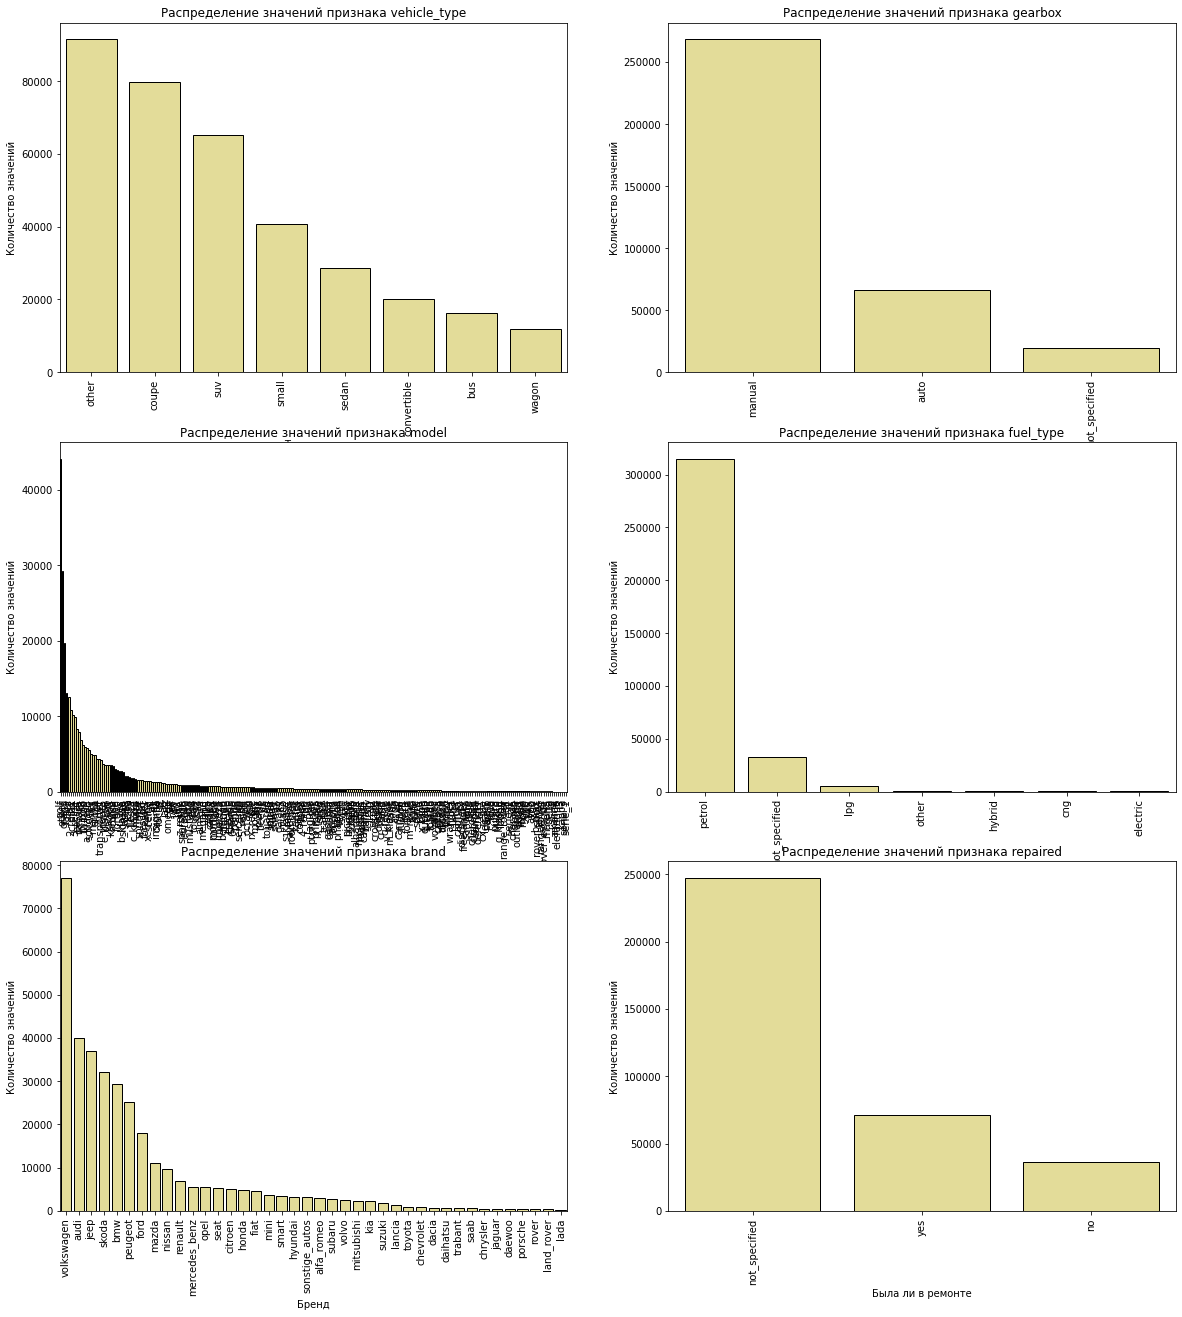

In [ ]:
# распределение количественных признаков
fig = plt.figure(figsize=(20,45))

x_labels_1 = [
    'Тип кузова',
    'Коробка передач',
    'Модель',
    'Тип топлива',
    'Бренд',
    'Была ли в ремонте'
]
total_axes = len(autos_cat_cols)
subplt = 1
for n, c in enumerate(autos[autos_cat_cols]):
    ax = fig.add_subplot(total_axes, 2, subplt, xlabel=x_labels_1[n])
    sns.barplot(
        x=autos[c].unique(),
        y=autos[c].value_counts(dropna=False),
        color='khaki',
        ec='black'
    )
    subplt += 1
    plt.title(f'Распределение значений признака {c}')
    plt.ylabel('Количество значений')
    plt.xticks(rotation=90)
pass

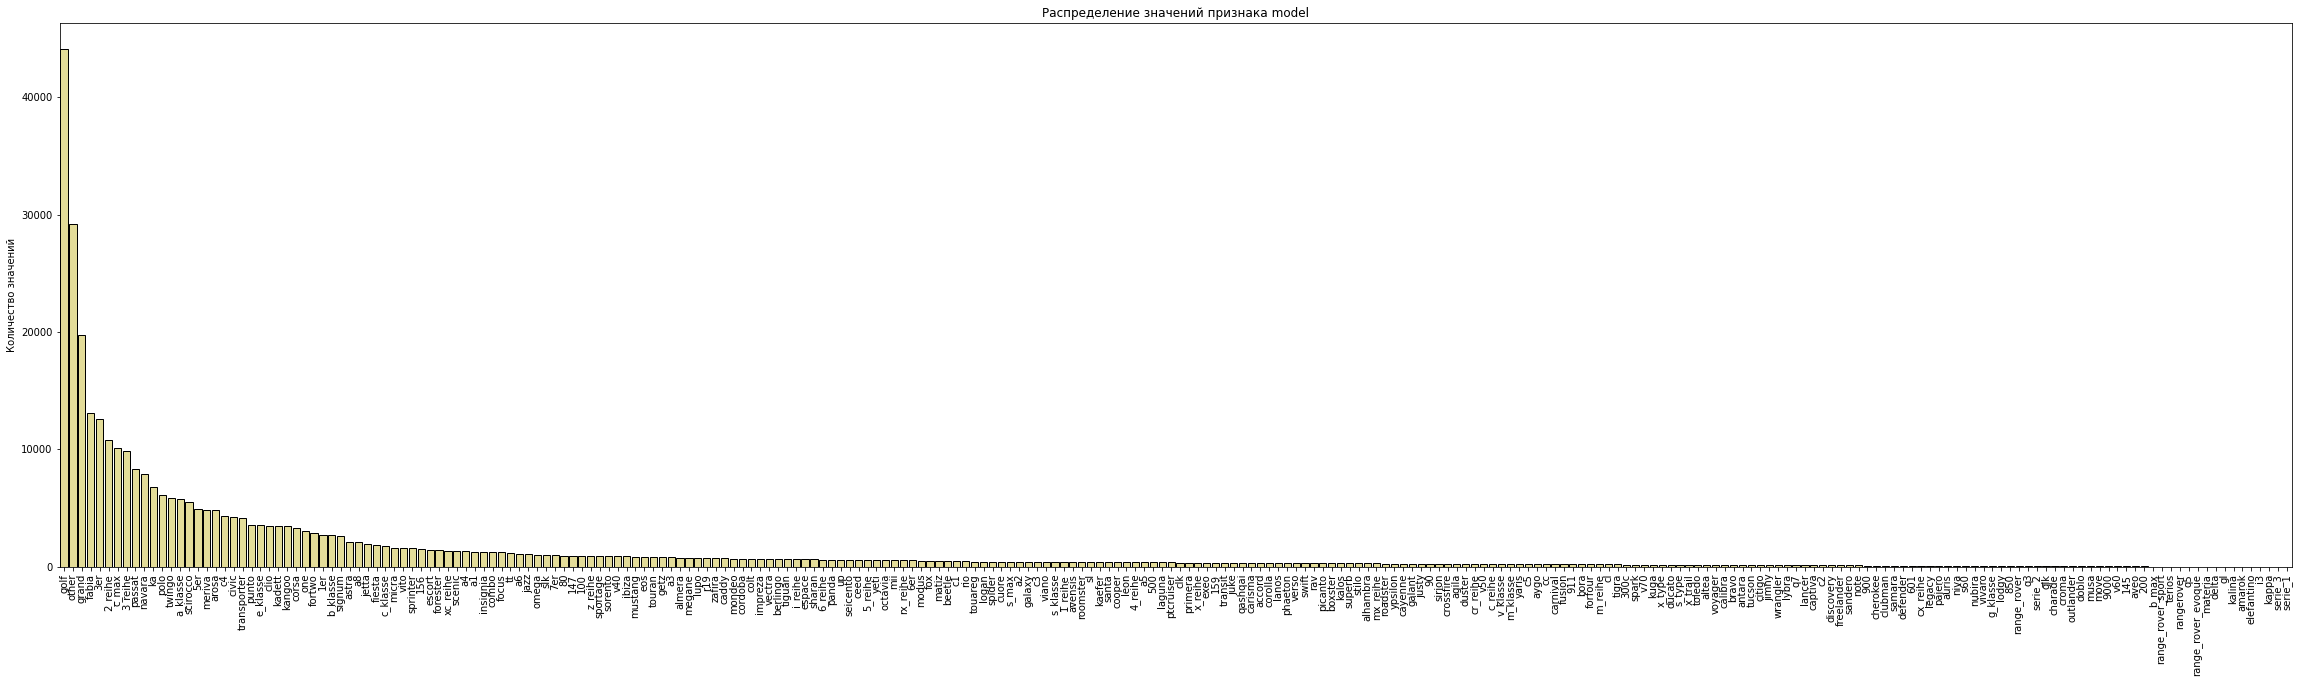

In [ ]:
# распределение признака model в более крупном масштабе
fig, ax = plt.subplots(figsize=(40, 10))
sns.barplot(
    x=autos['model'].unique(),
    y=autos['model'].value_counts(),
    color='khaki',
    ec='black')

plt.title(f'Распределение значений признака model')
plt.ylabel('Количество значений')
plt.xticks(rotation=90)

pass

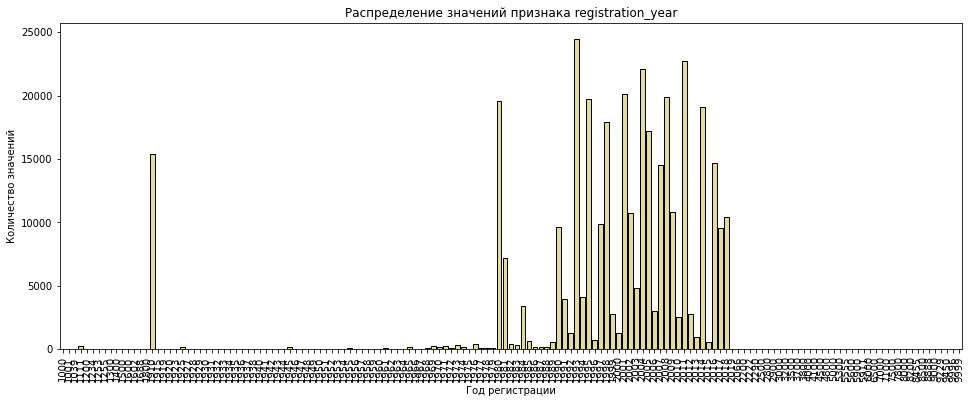

In [ ]:
# распределение дискретных количественных признаков
fig = plt.figure(figsize=(55,6))

x_labels_2 = [
    'Год регистрации'
]
total_axes = len(autos_discr_cat_cols)
subplt = 1
for n, c in enumerate(autos[autos_discr_cat_cols]):
    ax = fig.add_subplot(total_axes, 3, subplt, xlabel=x_labels_2[n])
    sns.barplot(
        x=autos[c].unique(),
        y=autos[c].value_counts(dropna=False),
        color='khaki',
        ec='black'
    )
    subplt += 1
    plt.title(f'Распределение значений признака {c}')
    plt.ylabel('Количество значений')
    plt.xticks(rotation=90)
pass

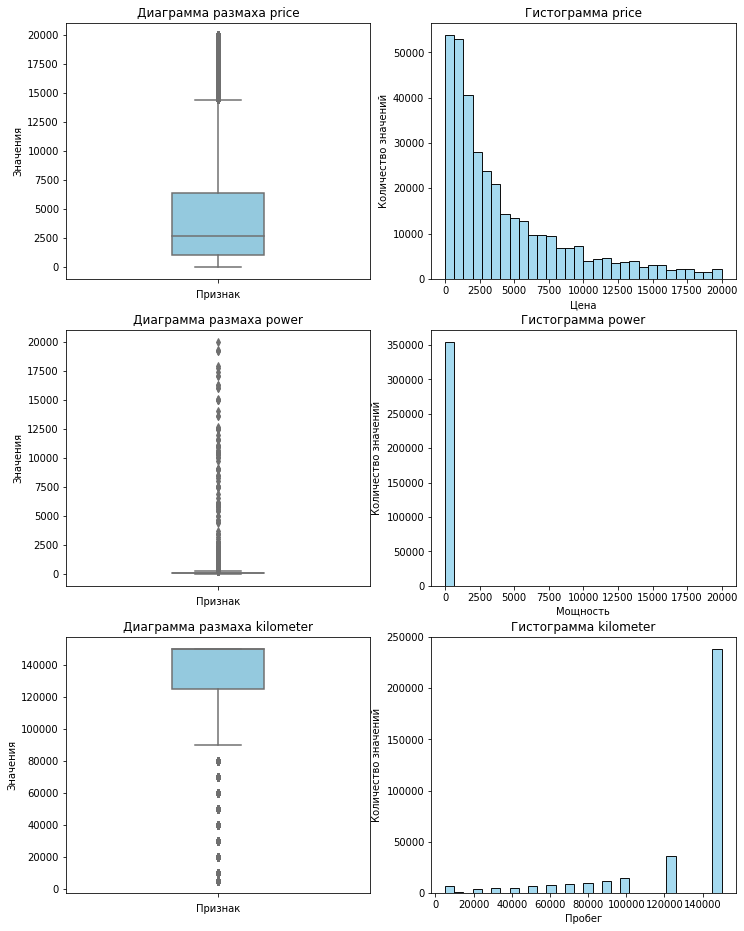

In [ ]:
# графики для количественных признаков (гистограммы и boxplot'ы)
x_labels_1_3 = [
    'Цена',
    'Мощность',
    'Пробег'
]

fig = plt.figure(figsize=(12,16))

total_axes = len(autos_num_cols)
subplt = 1
for n, c in enumerate(autos[autos_num_cols]):
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.boxplot(y=autos[c], color='skyblue', width=.3)
    subplt += 1
    plt.title(f'Диаграмма размаха {c}')
    plt.xlabel('Признак')
    plt.ylabel('Значения')
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.histplot(autos[c], color='skyblue', ec='black', bins=30)
    subplt += 1
    plt.title(f'Гистограмма {c}')
    plt.xlabel(x_labels_1_3[n])
    plt.ylabel('Количество значений')
pass

- Автомобили вряд ли отдают бесплатно, поэтому price = 0 - скорее аномальное значение (при этом на боксплоте не является выбросом). В то же время слишком маленькая цена (например, 1 евро), тоже странная. Это можно попробовать объяснить тем, что продавцы просто отдают неработоспособное авто, лишь бы забрали. <br>
Посмотрим на количество таких объявлений:

In [ ]:
print('Количество значений price = 0:', autos.query('price == 0')['price'].count())
print('Количество значений price > 0 но < 10:', autos.query('price > 0.1 and price < 10')['price'].count())

Количество значений price = 0: 10772
Количество значений price > 0 но < 10: 1256


In [ ]:
# взглянем на картину шире
autos.query('price < 10')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,other,1990,not_specified,0,corsa,150000,petrol,opel,not_specified
59,1,suv,1994,manual,286,other,150000,not_specified,sonstige_autos,not_specified
89,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
111,0,other,2017,manual,0,golf,5000,petrol,volkswagen,not_specified
...,...,...,...,...,...,...,...,...,...,...
354205,0,other,2000,manual,65,corsa,150000,not_specified,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,not_specified
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,not_specified
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [ ]:
# количество выбросов в price
autos.query('price > 14500')['price'].count()

17820

В этой выборке есть как старые авто, так и новые, с разным пробегом, отремонтированные и нет. Удалим объекты с ценой, равной 0 (предполагая, что цену просто не указали), как аномальные. Остальные авто с низкой ценой оставим (предположим, что их отдают лишь бы забрали).<br>
При этом выбросы (по boxplot) удалять не будем.

In [ ]:
autos = autos.query('price > 0')

- В признаке registration_year видим множество аномальных значений.<br>
Год появления первого автомобиля - 1886. Конечно, эти раритеты будут стоить очень много, но зацепимся за эту дату, как за начало отчета. <br>
Максимальный год — год выгрузки (date_crawled) - 2016. Это будет верхний порог. Удалим аномалии:

In [ ]:
autos = autos.query('registration_year >= 1886 and registration_year <= 2016')
autos['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1966,
       1975, 1963, 1964, 1960, 1958, 1967, 1959, 1956, 1941, 1962, 1929,
       1957, 1940, 1949, 1937, 1951, 1953, 1954, 1950, 1948, 1952, 1932,
       1942, 1935, 1933, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928,
       1931, 1947, 1927, 1946])

- Согласно данным интернета 1 место по количеству лошадиных сил среди автомобилей (не берем спецтехнику) занимает Devel Sixteen Engine Dyno, 4515 л. с. Оставим это значение, как верхний предел. <br>
Ноль лошадиных сил - предположим, что это окно просто не заполнили.<br>
Что касается маленьких значений, то в списке присутствует fiat 500, у которого количество 'лошадей'  13-135. Похоже, это самая маломощная машина в датасете. Будем ориентироваться на 13 л.с., как на минимальное значение.

In [ ]:
print('Количество объектов с power < 1:', autos.query('power < 1')['power'].count())
print('Количество объектов с power < 13:', autos.query('power < 13')['power'].count())
print('Количество объектов с power > 4515:', autos.query('power > 4515')['power'].count())

Количество объектов с power < 1: 32866
Количество объектов с power < 13: 33130
Количество объектов с power > 4515: 73


Получаем довольно много значений с power < 1. Удалим их.<br>
Можно заменить нули средним значением или, например, медианой, но насколько хорошо это будет отражать реальную ситуацию? Оставим нули, как есть, при этом удалим объекты с power > 4515 л.с.

In [ ]:
autos = autos.query('0 < power < 4515')

- Boxplot показывает, что в kilometer есть выбросы (значения < 90000). Удалять не будем.

- registration_month: есть значения месяца 0 и есть 12... но этот признак ранее был удален, как неинформативный.

In [ ]:
# итоговая форма DataFrame
autos.shape

(296822, 10)

In [ ]:
# за время манипуляций с DataFrame могли появиться дубликаты
autos.duplicated().sum()

39892

In [ ]:
# удалим их
autos.drop_duplicates(inplace=True)

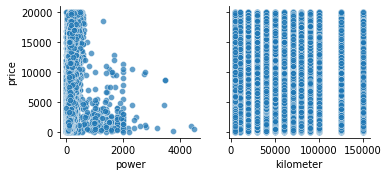

In [ ]:
# построим диаграммы рассеяния для целевого признака и всех количественных признаков без учёта значений категориальных признаков (долго грузится код).
g = sns.PairGrid(autos, x_vars=autos_num_cols[1:], y_vars='price')
g.map(sns.scatterplot, alpha=0.7)
g.add_legend()
pass

Какой-то красивой зависимости не наблюдается.

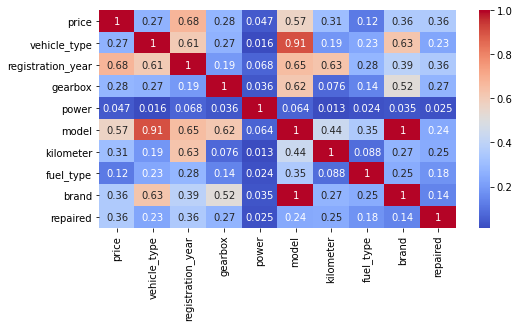

In [ ]:
# матрица корреляций. Используем коэффициент корреляции фи, который учитывает категориальные признаки, а также ненормальность распределения данных
fig = plt.figure(figsize=(8, 4))

sns.heatmap(
    autos.phik_matrix(interval_cols=autos_num_cols),
    cmap='coolwarm',
    annot=True,
    fmt='.2g'
)
pass

Судя по матрицам корреляций, мультиколлинеарность наблюдается (о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю).
Сильная корреляция у модели и типа кузова, что логично. 0.9 проходит по условной границе мультиколлинеарности. Пока оставим оба признака, но будем иметь ввиду данный момент.

=== Примечание: при удалении одного из признаков (vehicle_type или model) значение метрики качества RMSE улучшается, но не критично (порядка 100 евро). ===

### Подготовка данных

In [ ]:
# сделаем ресет индекса, удалим появившийся столбец index, сделав из него индекс
autos = autos.reset_index().set_index('index')

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
ord_columns = []
num_columns = ['registration_year', 'power', 'kilometer']

In [ ]:
# разделение DataFrame на 2 группы: целевой признак и входные признаки
X = autos.drop(['price'], axis=1)
y = autos['price']

In [ ]:
# разбивка выборки на тренировочную и валидационную
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(192697, 9)

(192697,)

(64233, 9)

(64233,)

In [ ]:
# кодирование данных, масштабирование данных, объединение в один DataFrame
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

# объединение в один DataFrame для дальнейшего обучения
# кодированные + мастшатированные признаки
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
df_X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
print('Размер таблицы отмасштабированных признаков X_train:', df_X_train_scaled.shape)
print('Размер таблицы кодированных признаков X_train:', df_X_train_ohe.shape)
df_X_train_merged = df_X_train_scaled.merge(df_X_train_ohe, right_index=True, left_index=True)
print('Размер таблицы объединенных признаков X_train:', df_X_train_merged.shape, '\n')

df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
df_X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
print('Размер таблицы отмасштабированных признаков X_test:', df_X_test_scaled.shape)
print('Размер таблицы кодированных признаков X_test:', df_X_test_ohe.shape)
df_X_test_merged = df_X_test_scaled.merge(df_X_test_ohe, right_index=True, left_index=True)
print('Размер таблицы объединенных признаков X_test:', df_X_test_merged.shape, '\n')

# изначальные качественные признаки + масштабированные
df_X_train_merged_2 = df_X_train_scaled.merge(X_train.drop(['power', 'kilometer'], axis=1).reset_index(), right_index=True, left_index=True)
print('Размер таблицы объединенных признаков X_train (незакодированные качественные + отмасштабированные):', df_X_train_merged_2.shape)
df_X_test_merged_2 = df_X_test_scaled.merge(X_test.drop(['power', 'kilometer'], axis=1).reset_index(), right_index=True, left_index=True)
print('Размер таблицы объединенных признаков X_test (незакодированные качественные + отмасштабированные):', df_X_test_merged_2.shape)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Размер таблицы отмасштабированных признаков X_train: (192697, 3)
Размер таблицы кодированных признаков X_train: (192697, 303)
Размер таблицы объединенных признаков X_train: (192697, 306) 

Размер таблицы отмасштабированных признаков X_test: (64233, 3)
Размер таблицы кодированных признаков X_test: (64233, 303)
Размер таблицы объединенных признаков X_test: (64233, 306) 

Размер таблицы объединенных признаков X_train (незакодированные качественные + отмасштабированные): (192697, 11)
Размер таблицы объединенных признаков X_test (незакодированные качественные + отмасштабированные): (64233, 11)


### Выводы

На данном этапе были подготовлены данные для дальнешего моделирования:
- удалены дубликаты;
- обработаны аномальные значения в признаках;
- заполнены пропущенные данные;
- удалены неинформативные признаки;
- произведена разбивка данных на тренировочнцю и валидационную;
- подготовлены списки для масштабирования и кодирования.

## Обучение модели

### Модель 1: LightGBM

In [ ]:
# перевод категориальных признаков в тип данных 'category', иначе LGBMRegressor не работает
df_X_train_merged_LGBMR = df_X_train_merged_2
df_X_test_merged_LGBMR = df_X_test_merged_2

df_X_train_merged_LGBMR[ohe_columns] = df_X_train_merged_2[ohe_columns].astype('category')
df_X_test_merged_LGBMR[ohe_columns] = df_X_test_merged_2[ohe_columns].astype('category')

In [ ]:
#  подбор гиперпараметров
model_LGBMR = lgb.LGBMRegressor(random_state=RANDOM_STATE)
param_grid = {
        'n_estimators': [250, 500], #количество деревьев в град. бустинге
        'max_depth': [i for i in range(6, 26, 6)] # максимальная глубина дерева
    }

grid_search = GridSearchCV(
    estimator=model_LGBMR,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error', # root_mean_squared_error не работает
    n_jobs=-1,
    verbose=2
)
grid_search.fit(df_X_train_merged_LGBMR, y_train)

print('Модель с лучшими гиперпараметрами и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика модели при кросс-валидации:', grid_search.best_score_ * (-1))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......................max_depth=6, n_estimators=250; total time=  11.4s
[CV] END ......................max_depth=6, n_estimators=250; total time=  11.1s
[CV] END ......................max_depth=6, n_estimators=250; total time=  12.5s
[CV] END ......................max_depth=6, n_estimators=500; total time=  21.1s
[CV] END ......................max_depth=6, n_estimators=500; total time=  24.9s
[CV] END ......................max_depth=6, n_estimators=500; total time=  23.4s
[CV] END .....................max_depth=12, n_estimators=250; total time=  12.4s
[CV] END .....................max_depth=12, n_estimators=250; total time=  12.7s
[CV] END .....................max_depth=12, n_estimators=250; total time=  11.0s
[CV] END .....................max_depth=12, n_estimators=500; total time=  19.9s
[CV] END .....................max_depth=12, n_estimators=500; total time=  21.7s
[CV] END .....................max_depth=12, n_est

Увеличение n_estimators улучает метрику качества, но увеличивает время работы. RMSE < 2500 достаточно для выполнения условия задачи.


### Модель 2: CatBoost

Работа с категориальными признаками. CatBoost уникален благодаря своей способности обрабатывать категориальные данные без необходимости в предварительном кодировании. Это позволяет значительно упростить подготовку данных и сохранить информацию, которая может быть утрачена при использовании методов вроде one-hot encoding.

In [ ]:
# подбор гиперпараметров
model_CB = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=autos_cat_cols)
param_grid = {
        'n_estimators': [250, 500], #количество деревьев в град. бустинге
        'max_depth': [i for i in range(6, 24, 6)] # максимальная глубина дерева
    }

grid_search = GridSearchCV(
    estimator=model_CB,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error', # root_mean_squared_error не работает
    n_jobs=-1,
    verbose=2
)
grid_search.fit(df_X_train_merged_2, y_train)

print('Модель с лучшими гиперпараметрами и её параметры:\n\n', grid_search.best_params_)
print ('Метрика модели при кросс-валидации:', grid_search.best_score_ * (-1))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Learning rate set to 0.272171
0:	learn: 3864.6264277	total: 232ms	remaining: 57.9s
1:	learn: 3320.2334477	total: 454ms	remaining: 56.3s
2:	learn: 2929.8131479	total: 615ms	remaining: 50.7s
3:	learn: 2651.9295218	total: 737ms	remaining: 45.3s
4:	learn: 2471.9817864	total: 908ms	remaining: 44.5s
5:	learn: 2338.0831566	total: 1.06s	remaining: 43.3s
6:	learn: 2223.7232099	total: 1.22s	remaining: 42.2s
7:	learn: 2142.5002773	total: 1.36s	remaining: 41.2s
8:	learn: 2086.6720593	total: 1.48s	remaining: 39.7s
9:	learn: 2047.1629026	total: 1.6s	remaining: 38.4s
10:	learn: 2016.6884191	total: 1.74s	remaining: 37.9s
11:	learn: 1992.7726238	total: 1.86s	remaining: 36.9s
12:	learn: 1972.3247890	total: 2.02s	remaining: 36.9s
13:	learn: 1956.5317254	total: 2.16s	remaining: 36.4s
14:	learn: 1945.7813003	total: 2.29s	remaining: 35.8s
15:	learn: 1935.1621034	total: 2.44s	remaining: 35.7s
16:	learn: 1916.1629322	total: 2.58s	remaining: 35.4s
17:

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_para

Learning rate set to 0.165168
0:	learn: 4108.7599966	total: 603ms	remaining: 5m
1:	learn: 3640.3350425	total: 1.32s	remaining: 5m 28s
2:	learn: 3269.2697118	total: 1.99s	remaining: 5m 29s
3:	learn: 2956.8295249	total: 2.74s	remaining: 5m 39s
4:	learn: 2703.8219005	total: 3.26s	remaining: 5m 22s
5:	learn: 2511.5729183	total: 3.95s	remaining: 5m 25s
6:	learn: 2359.4228735	total: 4.72s	remaining: 5m 32s
7:	learn: 2238.5607930	total: 5.21s	remaining: 5m 20s
8:	learn: 2145.5515695	total: 5.95s	remaining: 5m 24s
9:	learn: 2070.5295411	total: 6.48s	remaining: 5m 17s
10:	learn: 2010.8862133	total: 7.08s	remaining: 5m 14s
11:	learn: 1959.1734710	total: 7.63s	remaining: 5m 10s
12:	learn: 1916.3389359	total: 8.23s	remaining: 5m 8s
13:	learn: 1882.3446355	total: 8.79s	remaining: 5m 5s
14:	learn: 1853.6210364	total: 9.33s	remaining: 5m 1s
15:	learn: 1824.5475019	total: 9.97s	remaining: 5m 1s
16:	learn: 1805.0824478	total: 10.5s	remaining: 4m 58s
17:	learn: 1789.7901144	total: 11.1s	remaining: 4m 58

### Модель 3: Линейная регрессия

In [ ]:
# обучение модели с помощью кросс-валидации
model_lr  = LinearRegression()

cv_lr = (cross_val_score(model_lr,
                         df_X_train_merged,
                         y_train,
                         cv=3,
                         scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE модели линейной регрессии, евро:', cv_lr)

RMSE модели линейной регрессии, евро: 2838.9548730771025


### Выводы

Было создано 3 модели машинного обучения: LGBMRegressor, CatBoostRegressor и модель линейной регрессии.<br>
Для моделей, использующих градиентный бустинг, были подобраны гиперпараметры так, чтобы RMSE был < 2500. <br>
В линейной модели перебора гиперпараметров не было.<br><br>
Больше всего времени занимает обрботка кода с подбором гиперпараметров, поэтому количесвто гиперпараметров было ограничено.

## Анализ моделей

### Модель 1: LightGBM

In [ ]:
%%time
# время обучения
model_LGBMR = lgb.LGBMRegressor(max_depth=18, n_estimators=500, random_state=42)
model_LGBMR.fit(df_X_train_merged_LGBMR, y_train)

CPU times: user 23.4 s, sys: 190 ms, total: 23.5 s
Wall time: 23.6 s


LGBMRegressor(max_depth=18, n_estimators=500, random_state=42)

In [ ]:
%%time
# время предсказания
preds_LGBMR = model_LGBMR.predict(df_X_train_merged_LGBMR)

CPU times: user 6.74 s, sys: 26.4 ms, total: 6.76 s
Wall time: 6.83 s


### Модель 2: CatBoost

In [ ]:
%%time
# время обучения
model_CB = CatBoostRegressor(n_estimators=500, max_depth=12, verbose=False,  cat_features=autos_cat_cols)
model_CB.fit(df_X_train_merged_2, y_train)

CPU times: user 5min 50s, sys: 715 ms, total: 5min 51s
Wall time: 5min 52s


In [ ]:
%%time
# время предсказания
preds_CB = model_CB.predict(df_X_train_merged_2)

CPU times: user 2.04 s, sys: 359 µs, total: 2.04 s
Wall time: 2.04 s


### Модель 3: Линейная регрессия

In [ ]:
%%time
# время обучения
model_lr  = LinearRegression()
model_lr.fit(df_X_train_merged, y_train)

CPU times: user 9.85 s, sys: 3.41 s, total: 13.3 s
Wall time: 13.3 s


LinearRegression()

In [ ]:
%%time
# время предсказания
preds_lr = model_lr.predict(df_X_train_merged)

CPU times: user 130 ms, sys: 15.6 ms, total: 146 ms
Wall time: 104 ms


### Выводы

Анализ моделей показал, что модель линейной регрессии хуже справилась с предсказанием цены автомобиля. Однако, можно повысить ее качество, улучшая признаки. <br>
В то же время, модели, работающие с помощью градиентного бустинга, при таком же качестве входных данных дают лучший результат. <br>
Для чистоты эксперимента для CatBoostRegressor и LGBMRegressor в качестве исходных были переданы одинаковые гиперпараметры.<br>
Сделаем выбор лушей модели в следующем разделе.

## Выбор лучшей модели и проверка ее качества

In [ ]:
# таблица сравнения работы моделей
result_df = pd.DataFrame(
    {'LGBMRegressor': [1629.79, 5.96, 8.37, 5.98, 10.5],
     'CatBoostRegressor': [1645.25, 345.0, 2.12, 346.0, 2.13],
     'LinearRegression': [2838.95, 12.9, 0.12, 12.9, 0.1]},
    index=['RMSE, евро', 'CPU times: обучение, сек', 'CPU times: предсказание, сек', 'Wall time: обучение, сек', 'Wall time: предсказание, сек']
)
result_df

,LGBMRegressor,CatBoostRegressor,LinearRegression
"RMSE, евро",1629.79,1645.25,2838.95
"CPU times: обучение, сек",5.96,345.00,12.90
"CPU times: предсказание, сек",8.37,2.12,0.12
"Wall time: обучение, сек",5.98,346.00,12.90
"Wall time: предсказание, сек",10.50,2.13,0.10


Таблица, представленная выше, показывает, что модель LGBMRegressor показывает лучшую целевую метрику, обучается быстрее других моделей; при этом предсказывает дольше остальных.<br>
Стоит отметить, что LGBMRegressor подбирал гиперпараметры существенно быстрее CatBoostRegressor.<br>
В качестве лучшей модели выберем LGBMRegressor.

In [ ]:
# проверка качества лучшей модели на тестовой выборке
preds_test = model_LGBMR.predict(df_X_test_merged_LGBMR)
rmse = mean_squared_error(y_test, preds_test) ** 0.5
print('RMSE лучшей модели на тестовой выборке, евро:', rmse)

RMSE лучшей модели на тестовой выборке, евро: 1591.5417272287254


### Выводы

В качестве лучшей модели выбран LGBMRegressor. <br>
Было проверено качество на тестовой выборке и оно соответствует требованиям задачи проекта (< 2500).

## Общие выводы

В настоящем проекте были проведены следующие этапы:<br>
1. Подготовлены данные для моделирования (удалены дубликаты, обработаны аномальные значения в признаках, заполнены пропущенные данные, удалены неинформативные признаки, произведена разбивка данных на тренировочнцю и валидационную, подготовлены списки для масштабирования и кодирования);<br>
2. Создано 3 модели машинного обучения: LGBMRegressor, CatBoostRegressor и модель линейной регрессии.<br>
Для моделей, использующих градиентный бустинг, были подобраны гиперпараметры так, чтобы RMSE был < 2500. <br>
В линейной модели перебора гиперпараметров не было.<br>
3. Проанализированы модели. Анализ моделей показал, что модель линейной регрессии хуже справилась с предсказанием цены автомобиля. Однако, можно повысить ее качество, улучшая признаки. <br>
В то же время, модели, работающие с помощью градиентного бустинга, при таком же качестве входных данных дают лучший результат. <br>
Для чистоты эксперимента для CatBoostRegressor и LGBMRegressor в качестве исходных были переданы одинаковые гиперпараметры.<br>
4. В качестве лучшей модели выбран LGBMRegressor. <br>
Было проверено качество на тестовой выборке и оно соответствует требованиям задачи проекта (< 2500).
<br><br><br>
Рекомендации заказчику<br>
Для дальнейшего использования с целью предсказания цены автомобиля рекомендуется модель LGBMRegressor. Она соответствует критериям, которые важны сервису "Не бит, не крашен": качество предсказания (метрика RMSE < 2500 евро), время обучения модели (лучше, чем у CatBoostRegressor), время предсказания модели (хуже, чем у главного конкурента CatBoostRegressor).<br>
Если же окажется, что время предсказания важнее, чем время обучения и метрика качества, то можно выбрать модель CatBoostRegressor.

